In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

In [2]:
FILEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed'
SAVEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/figs'
REGIONS = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':19.5,'lonmin':64.,'lonmax':72.}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Central Bay of Bengal':{'latmin':9.,'latmax':14.5,'lonmin':86.5,'lonmax':90.},
    'Equatorial Indian Ocean':{'latmin':5.,'latmax':10.,'lonmin':62.,'lonmax':67.5},
    'Konkan Coast':{'latmin':15.,'latmax':19.5,'lonmin':69.,'lonmax':72.5}} 
BINPARAMS = {
    'bl':{'min':-0.6,'max':0.1,'width':0.0025},
    'cape':{'min':-70.,'max':20.,'width':1.},
    'subsat':{'min':-20.,'max':70.,'width':1.}}
SAMPLETHRESH = 50
PRTHRESH     = 0.25

In [3]:
def load(filename,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    return ds.load()

In [20]:
loresstats = load('ERA5_GPCP_binned_stats.nc')
hiresstats = load('ERA5_IMERG_binned_stats.nc')
lorespbl = load('ERA5_GPCP_pr_bl_terms.nc')
hirespbl = load('ERA5_IMERG_pr_bl_terms.nc')

In [34]:
def get_region(data,key,regions=REGIONS):
    region = regions[key]
    return data.sel(lat=slice(region['latmin'],region['latmax']),lon=slice(region['lonmin'],region['lonmax']))

# def get_month(data,month):
#     return data.sel(time=data.time.dt.month==month)

def get_month(data,months):
    if not isinstance(months,(list,tuple)):
        months = [months]
    monthmask = data.time.dt.month.isin(months)
    return data.sel(time=monthmask)

def get_pdf(stats,bintype,precipitating,samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        Q0 = stats.Q0.values
        QE = stats.QE.values
        Q  = QE if precipitating else Q0
        Q[Q<samplethresh] = np.nan
        pdf = Q/np.nansum(Q)
        return xr.DataArray(pdf,coords={'bl':stats.bl.values})
    elif bintype=='2D':
        P0  = stats.P0.values
        PE  = stats.PE.values
        P   = PE if precipitating else P0
        pdf = PE/(np.nansum(P0)*np.diff(stats.subsat.values)[0]*np.diff(stats.cape.values)[0])
        subsatmaxidx,capemaxidx = np.where(P==np.nanmax(P))
        subsatmaxidx,capemaxidx = subsatmaxidx[0],capemaxidx[0]
    return xr.DataArray(pdf,coords={'subsat':stats.subsat.values,'cape':stats.cape.values}),subsatmaxidx,capemaxidx
    
def get_bin_mean_pr(stats,bintype='1D',samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        coords = {'bl':stats.bl.values}
        Q0 = stats.Q0.values
        Q1 = stats.Q1.values
        Q0[Q0==0.0] = np.nan
        binmeanpr = Q1/Q0
        binmeanpr[Q0<samplethresh] = np.nan
    if bintype=='2D':
        coords = {'subsat':stats.subsat.values,'cape':stats.cape.values}
        P0 = stats.P0.values
        P1 = stats.P1.values
        P0[P0==0.0] = np.nan
        binmeanpr = P1/P0
        binmeanpr[P0<samplethresh] = np.nan
    return xr.DataArray(binmeanpr,coords=coords)

def calc_pr_diffs(stats,data,regions=REGIONS):
    predprdiffs = []
    realprdiffs = []
    for i,region in enumerate(regions):
        months = [6,7] if i<3 else [7,8]
        regionstats = stats.sel(region=region,month=months)
        regiondata  = get_region(data,region)
        binmeanpr = get_bin_mean_pr(regionstats.sum(dim='month'),bintype='1D')
        predprlist = []
        realprlist = []
        for month in months:
            monthstats = regionstats.sel(month=month)
            monthdata  = get_month(regiondata,month)
            blpdf = get_pdf(monthstats,bintype='1D',precipitating=False)
            predpr = np.nansum(blpdf*binmeanpr)
            realpr = monthdata.pr.mean(dim=['lat','lon','time']).values
            predprlist.append(predpr)
            realprlist.append(realpr)
        predprdiffs.append(predprlist[1]-predprlist[0])
        realprdiffs.append(realprlist[1]-realprlist[0])
    return np.asarray(predprdiffs),np.asarray(realprdiffs)

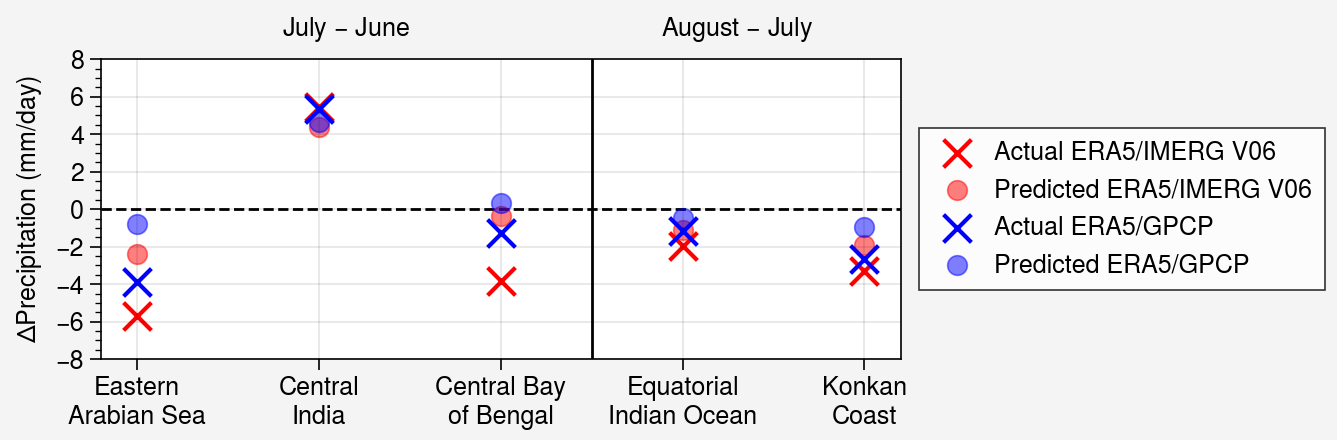

In [35]:
hirespreddiffs,hiresrealdiffs = calc_pr_diffs(hiresstats,hirespbl)
lorespreddiffs,loresrealdiffs = calc_pr_diffs(loresstats,lorespbl)

titlekwargs  = dict(ha='center',va='bottom')
linekwargs   = dict(color='k',linewidth=1,zorder=0)

regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
fig,ax  = pplt.subplots(refheight=1.5,refwidth=4)
ax.format(ylabel='$\Delta$Precipitation (mm/day)',ylim=(-8,8),yticks=2)
ax.text(x=1.15,y=ax.get_ylim()[1]+0.8,s='July $-$ June',**titlekwargs)
ax.text(x=3.3,y=ax.get_ylim()[1]+0.8,s='August $-$ July',**titlekwargs)
ax.axvline(x=2.5,**linekwargs)
ax.axhline(y=0,linestyle='--',**linekwargs)
ax.scatter(regions,hiresrealdiffs,label='Actual ERA5/IMERG V06',color='r',marker='x',s=100)
ax.scatter(regions,hirespreddiffs,label='Predicted ERA5/IMERG V06',color='r',marker='o',s=50,alpha=0.5)
ax.scatter(regions,loresrealdiffs,label='Actual ERA5/GPCP',color='b',marker='x',s=100)
ax.scatter(regions,lorespreddiffs,label='Predicted ERA5/GPCP',color='b',marker='o',s=50,alpha=0.5)
ax.legend(loc='r',ncols=1)
pplt.show()
# fig.save(f'{SAVEDIR}/fig_4.png',dpi=900)

In [39]:
print('ERA5/GPCP')
for region,preddiff,realdiff in zip(REGIONS.keys(),lorespreddiffs,loresrealdiffs):
    print(f'{region}:')
    print(f'- Real P diff: {realdiff:.1f} mm/day')
    print(f'- Predicted P diff: {preddiff:.1f} mm/day')
    percenterror = ((preddiff-realdiff)/realdiff)*100
    print(f'- Percent error: {percenterror:.1f}%')

print('ERA5/IMERG V05')
for region,preddiff,realdiff in zip(REGIONS.keys(),hirespreddiffs,hiresrealdiffs):
    print(f'{region}:')
    print(f'- Real P diff: {realdiff:.1f} mm/day')
    print(f'- Predicted P diff: {preddiff:.1f} mm/day')
    percenterror = ((preddiff-realdiff)/realdiff)*100
    print(f'- Percent error: {percenterror:.1f}%')

ERA5/GPCP
Eastern Arabian Sea:
- Real P diff: -3.9 mm/day
- Predicted P diff: -0.8 mm/day
- Percent error: -80.0%
Central India:
- Real P diff: 5.3 mm/day
- Predicted P diff: 4.6 mm/day
- Percent error: -13.1%
Central Bay of Bengal:
- Real P diff: -1.3 mm/day
- Predicted P diff: 0.3 mm/day
- Percent error: -125.7%
Equatorial Indian Ocean:
- Real P diff: -1.1 mm/day
- Predicted P diff: -0.5 mm/day
- Percent error: -57.6%
Konkan Coast:
- Real P diff: -2.6 mm/day
- Predicted P diff: -1.0 mm/day
- Percent error: -63.5%
ERA5/IMERG V05
Eastern Arabian Sea:
- Real P diff: -5.7 mm/day
- Predicted P diff: -2.4 mm/day
- Percent error: -57.5%
Central India:
- Real P diff: 5.4 mm/day
- Predicted P diff: 4.4 mm/day
- Percent error: -19.5%
Central Bay of Bengal:
- Real P diff: -3.8 mm/day
- Predicted P diff: -0.4 mm/day
- Percent error: -90.3%
Equatorial Indian Ocean:
- Real P diff: -2.0 mm/day
- Predicted P diff: -1.1 mm/day
- Percent error: -43.0%
Konkan Coast:
- Real P diff: -3.3 mm/day
- Predict